In [1]:
#import necessary libraries for classification

from collections import Counter
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras import metrics
from keras import backend as K
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from scipy import linalg, stats
from sklearn.preprocessing import StandardScaler
import gc
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn
plt.style.use('seaborn-whitegrid')
from gatspy import datasets, periodic
import pywt
from scipy.interpolate import UnivariateSpline

Using TensorFlow backend.
/Users/manojna/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/manojna/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/manojna/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/manojna/opt/anaconda3/lib/pytho

In [2]:
#reading the data and writing to pandas dataframes

train_series = pd.read_csv('training_set.csv')
train_metadata = pd.read_csv('training_set_metadata.csv')

#creating a list with all the unique object identifiers
ids = train_metadata['object_id'].unique()

train_series.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [3]:
#Discrete Wavelet Transform with PCA
#will help to extract dynamic characteristics
#of the data with relatively few features

#Smoothing spline regression technique to create
#evenly-spaced points since wavelet transform
#cannot accept two axes of information
def interpolate_signal(obj_id, band):
    
    #selecting time and flux data for the object
    t = (train_series.loc[train_series['object_id'] == obj_id][train_series['passband'] == band]['mjd'])
    f = (train_series.loc[train_series['object_id'] == obj_id][train_series['passband'] == band]['flux'])
    
    #cubic univariate spline function generation
    #where if loop handles case when there are 
    #three or less points
    if len(t) > 3:
        s0 = UnivariateSpline(t, f)
    elif len(t) == 3:
        s0 = UnivariateSpline(t, f, k=2)
    elif len(t) == 2:
        s0 = UnivariateSpline(t, f, k=1)
    elif len(t) == 1:
        s0 = UnivariateSpline(t, f, k=0)
    
    return s0, t.min(), t.max()

In [4]:
#discrete wavelet transform for light curve
#in single passband
def single_dwt(obj_id, band):
    #performing interpolation, selecting grid
    #in time (x) upon which to project
    interp, tmin, tmax = interpolate_signal(obj_id, band)
    x = np.linspace(tmin, tmax, 100) 
    y0 = interp(x)
    
    #padding the edges with constant values to
    #avoid edge effects from high-dimensional
    #wavelet transform
    y0 = pywt.pad(y0, 16, 'constant')
    
    #discrete wavelet transform on two levels using daubechies wavelet
    wav = pywt.wavedec(y0, wavelet = 'db1', level = 7)

    #concatenating the large-scale and small-scale frequencies detected
    wav_coefficients, wav_details = pywt.coeffs_to_array(wav)
    
    return wav_coefficients

#combine all wavelet transforms across all objects
def get_dynamic_feats():
    #create a new dataframe with ids
    dynamic_feats = pd.DataFrame(ids, columns = ['object_id'])
    
    #populate columns with dwt for each band
    dynamic_feats['dwt_0'] = dynamic_feats.apply(lambda row: single_dwt(row['object_id'], 0), axis = 1)
    dynamic_feats['dwt_1'] = dynamic_feats.apply(lambda row: single_dwt(row['object_id'], 1), axis = 1)
    dynamic_feats['dwt_2'] = dynamic_feats.apply(lambda row: single_dwt(row['object_id'], 2), axis = 1)
    dynamic_feats['dwt_3'] = dynamic_feats.apply(lambda row: single_dwt(row['object_id'], 3), axis = 1)
    dynamic_feats['dwt_4'] = dynamic_feats.apply(lambda row: single_dwt(row['object_id'], 4), axis = 1)
    dynamic_feats['dwt_5'] = dynamic_feats.apply(lambda row: single_dwt(row['object_id'], 5), axis = 1)
    
    del dynamic_feats['object_id']
    
    return dynamic_feats

In [5]:
untransformed = get_dynamic_feats()
untransformed.head()

/Users/manojna/opt/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/manojna/opt/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/manojna/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/Users/manojna/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation re

,dwt_0,dwt_1,dwt_2,dwt_3,dwt_4,dwt_5
0,"[5375.040411546442, 1373.9003565133812, 7859.7...","[-3249.942877261891, 6873.117362379594, -10440...","[-1385.0475017218764, 6247.604110268474, -9427...","[-2948.2131531163386, 3360.1063668012807, -714...","[-2186.1558361026728, 2667.736189621695, -7430...","[-2028.4167640603582, 1777.17555515585, -7627...."
1,"[-1080.079486960495, -98.35795249338146, -112....","[-19.89944488050999, -104.91911576718549, 75.1...","[-49.553699593246414, -76.77533548790115, 84.4...","[-79.5241463059048, -113.8059367753093, 94.319...","[-76.05106756568841, -64.67146300595108, 85.50...","[203.348817657888, -108.50971893627246, -374.5..."
2,"[254.40848768058316, 19.96332815525577, 71.711...","[-8.00454874921717, -0.28996080314815803, -5.8...","[47.50553587393193, 16.549564763832027, -46.43...","[86.51031792604749, 15.15672519310045, -0.2195...","[150.50443603224448, -27.241297176173646, 169....","[-36.96746635151045, -16.95213417282551, 36.52..."
3,"[791.601129598547, -14.316186515696305, 1054.3...","[535.4120044696987, 11.629624036579639, 508.47...","[528.2222611959604, -12.357781134066084, 504.4...","[438.1546395119418, -2.54154313242731, 411.989...","[383.87819263588284, -30.772316202538676, 476....","[544.6964423367353, 38.183250847384826, 471.26..."
4,"[72.13375983682033, 16.692369527619814, -125.1...","[91.67615503640428, 46.07926146895451, -86.998...","[412.6073149262756, 77.22043247496191, -396.86...","[582.04227493518, 60.577782479179554, -629.881...","[399.63698051093934, 35.83990992170139, -448.3...","[156.3094655222369, 73.79391357338817, -366.74..."


In [6]:
#PCA to convert wavelet transform of a
#single band to a single feature
def covar_PCA(band):
    #reshaping the array so that
    #the covariance matrix can be applied
    oldwav = pd.DataFrame((untransformed['dwt_{}'.format(band)]).tolist())
    oldwav = oldwav.values
    m, n = oldwav.shape
    #centering the data around the mean
    #for each coefficient
    oldwav -= oldwav.mean(axis = 0)
    
    #calculating the covariance matrix
    covar = np.cov(oldwav, rowvar = False)
    #calculating the eigenvalues and eigenvectors
    #of the (symmetrical) covariance matrix
    evals, evecs = linalg.eigh(covar)
    
    #sorting eigenvalues in decreasing order
    #while keeping indices consistent between
    #evals and evecs
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:, idx]
    evals = evals[idx]
    #selecting the most important eigenvector
    evecs = evecs[:, :1]
    
    newwav = np.dot(evecs.T, oldwav.T).T
    
    return newwav #newwav

In [7]:
#Lomb-Scargle Multiband Periodic Fit
#will extract features pertaining to periodicity
#from the light curves while incorporating the
#correlation of light in different passbands
#for unevenly sampled data

def fit_multiband(obj_id):
    #time, flux, flux error, and passband series
    t = train_series[train_series['object_id'] == obj_id]['mjd']
    f = train_series[train_series['object_id'] == obj_id]['flux']
    e = train_series[train_series['object_id'] == obj_id]['flux_err']
    b = train_series[train_series['object_id'] == obj_id]['passband']
    
    #parameterizing and fitting the model
    model = periodic.LombScargleMultibandFast(fit_period= True);
    
    #period range chosen on the assumption that
    #the period will be between 2.4 hours and half
    #of the observation window
    model.optimizer.period_range = (0.1, int((t.max()-t.min())/2));
    model.fit(t, f, e, b);
    
    #accuracy of fit for the model's best predicted period
    best_period_score = model.score(model.best_period);
    
    #returns tuple of best predicted period and its fit score
    return [model.best_period, float(best_period_score)]


In [8]:
#A naive benchmark to test whether an object has 
#occurred within or beyond the galaxy can be useful
#for distinguishing between classes

def extragalactic_benchmark(obj_id):
    #selecting the host galaxy redshift of the object
    #from the metadata; if it is 0, then the object
    #has been observed within the Milky Way
    hg_redshift = float(train_metadata[train_metadata['object_id'] == obj_id]['hostgal_photoz'])
    
    #will return true if the object is extragalactic
    if hg_redshift == 0:
        return False
    else:
        return True

In [9]:
#extracting features from timeseries

#garbage collector is useful as I manipulate
#timeseries and metadata to extract features
gc.enable() 

#extracting descriptive statistics about the time series
statistical_features = {
    'mjd': ['min', 'max', 'size'],
    'flux': ['min', 'max', 'mean', 'median', 'std'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std', 'skew'],
    'detected': ['mean']}

#simplifying the dataframe
train_feat = train_series.groupby(['object_id', 'passband']).agg(statistical_features)
new_columns = [k + '_' + agg for k in statistical_features.keys() for agg in statistical_features[k]]
train_feat.columns = new_columns

#considering the delta of time and flux
#for each object in each passband
train_feat['mjd_diff'] = train_feat['mjd_max']-train_feat['mjd_min']
train_feat['flux_diff'] = train_feat['flux_max']-train_feat['flux_min']
del train_feat['mjd_max'], train_feat['mjd_min']

gc.collect()
train_feat.head()

mjd_size     flux_min    flux_max   flux_mean  \
object_id passband                                                  
615       0               63  -116.913223  125.182808   -3.254554   
          1               58 -1100.440063  660.626343 -385.699911   
          2               58  -681.858887  611.984558 -134.146566   
          3               58  -530.644592  445.737061 -121.103501   
          4               58  -422.184509  381.953735  -55.954592   

                    flux_median    flux_std  flux_err_min  flux_err_max  \
object_id passband                                                        
615       0          -10.015225   83.944735      2.844200      4.737393   
          1         -488.057969  601.787302      3.034533      6.952323   
          2         -265.686004  455.121346      2.130510      4.333287   
          3         -162.170944  335.425053      2.499724      4.011444   
          4         -103.541366  291.803449      2.899512     11.395031   

                    flux_err_mean  flux_err_median  flux_err_std  \
object_id passband                                                 
615       0              3.823448         3.866380      0.493621   
          1              5.029014         4.980931      1.167671   
          2              3.380299         3.387887      0.579596   
          3              3.340116         3.388196      0.347401   
          4              3.798761         3.625775      1.088843   

                    flux_err_skew  detected_mean  mjd_diff    flux_diff  
object_id passband                                                       
615       0             -0.038907       0.857143  797.8763   242.096031  
          1              0.002414       0.965517  873.7530  1761.066406  
          2             -0.232705       0.982759  873.7531  1293.843445  
          3             -0.227460       0.982759  873.7530   976.381653  
          4              6.135947       0.982759  873.7572   804.138244

In [10]:
#making it so that each object is represented by one row
bands = [0, 1, 2, 3, 4, 5]

#creating the dataframe based on object id
rearranged = pd.DataFrame(ids, columns = ['object_id'])

for band in bands:
    banddata = train_feat.groupby(['passband']).get_group(band)

    rearranged['mjd_size_{}'.format(band)] = np.asarray(banddata['mjd_size'])
    rearranged['flux_min_{}'.format(band)] = np.asarray(banddata['flux_min'])
    rearranged['flux_max_{}'.format(band)] = np.asarray(banddata['flux_max'])
    rearranged['flux_mean_{}'.format(band)] = np.asarray(banddata['flux_mean'])
    rearranged['flux_median_{}'.format(band)] = np.asarray(banddata['flux_median'])
    rearranged['flux_std_{}'.format(band)] = np.asarray(banddata['flux_std'])
    rearranged['detected_mean_{}'.format(band)] = np.asarray(banddata['detected_mean'])
    rearranged['flux_err_min_{}'.format(band)] = np.asarray(banddata['flux_err_min'])
    rearranged['flux_err_max_{}'.format(band)] = np.asarray(banddata['flux_err_max'])
    rearranged['flux_err_mean_{}'.format(band)] = np.asarray(banddata['flux_err_mean'])
    rearranged['flux_err_median_{}'.format(band)] = np.asarray(banddata['flux_err_median'])
    rearranged['flux_err_std_{}'.format(band)] = np.asarray(banddata['flux_err_std'])
    rearranged['flux_err_skew_{}'.format(band)] = np.asarray(banddata['flux_err_skew'])
    rearranged['mjd_diff_{}'.format(band)] = np.asarray(banddata['mjd_diff'])
    rearranged['flux_diff_{}'.format(band)] = np.asarray(banddata['flux_diff'])

rearranged.head()

,object_id,mjd_size_0,flux_min_0,flux_max_0,flux_mean_0,flux_median_0,flux_std_0,detected_mean_0,flux_err_min_0,flux_err_max_0,...,flux_std_5,detected_mean_5,flux_err_min_5,flux_err_max_5,flux_err_mean_5,flux_err_median_5,flux_err_std_5,flux_err_skew_5,mjd_diff_5,flux_diff_5
0,615,63,-116.913223,125.182808,-3.254554,-10.015225,83.944735,0.857143,2.844200,4.737393,...,294.779522,0.912281,6.073453,12.845472,7.636021,7.310321,1.317882,1.530410,871.7697,801.003235
1,713,70,-14.735178,14.509829,-2.720398,-3.096804,7.113509,0.142857,1.470152,3.348282,...,7.094073,0.000000,3.523145,9.115748,5.314447,5.082915,1.187223,0.868721,842.8194,28.982050
2,730,72,-3.459960,5.942166,-0.048080,0.024093,1.828872,0.000000,1.132809,3.110694,...,13.332758,0.078431,4.175368,11.281384,6.011377,5.711615,1.309769,1.476630,853.8084,66.469870
3,745,72,-3.874349,18.014029,1.797523,1.056714,4.374445,0.027778,0.957792,3.093587,...,26.060130,0.127273,3.737703,55.892746,6.698346,5.399205,6.924616,6.883115,853.6683,151.762677
4,1124,63,-6.804703,5.330927,0.660948,0.581027,2.360084,0.000000,1.208098,3.658313,...,21.434627,0.070175,4.590859,11.383690,6.523610,6.032955,1.439684,1.103381,871.7697,120.018125


In [11]:
#delete features in metadata that are 
#not directly applicable to classification
del train_metadata['ra'], train_metadata['decl'], train_metadata['gal_l'], train_metadata['gal_b'], train_metadata['distmod']
del train_metadata['hostgal_specz']
del train_metadata['mwebv'], train_metadata['ddf']
gc.collect()
train_metadata.head()

,object_id,hostgal_photoz,hostgal_photoz_err,target
0,615,0.0000,0.0000,92
1,713,1.6267,0.2552,88
2,730,0.2262,0.0157,42
3,745,0.2813,1.1523,90
4,1124,0.2415,0.0176,90


In [12]:
%%capture
#merge extracted features with metadata

#adding features from discrete wavelet transform
train_metadata['wav_coeffs_0'] = covar_PCA(0)
train_metadata['wav_coeffs_1'] = covar_PCA(1)
train_metadata['wav_coeffs_2'] = covar_PCA(2)
train_metadata['wav_coeffs_3'] = covar_PCA(3)
train_metadata['wav_coeffs_4'] = covar_PCA(4)
train_metadata['wav_coeffs_5'] = covar_PCA(5)

#adding features from Lomb Scargle multiband fit
train_metadata['periodicity'] = train_metadata.apply(lambda row: fit_multiband(row['object_id']), axis = 1)

#adding extragalactic naive benchmark
train_metadata['extragalactic'] = train_metadata.apply(lambda row: extragalactic_benchmark(row['object_id']), axis = 1)

In [13]:
#merging timeseries with metadata
full_train = rearranged.reset_index().merge(
    right = train_metadata,
    how = 'outer',
    on = 'object_id')

#creating series for the targets
#and object identifiers
y = full_train['target']
obj_ids = full_train['object_id']
del full_train['target'], full_train['object_id'], full_train['index']

gc.collect()
full_train.head()

,mjd_size_0,flux_min_0,flux_max_0,flux_mean_0,flux_median_0,flux_std_0,detected_mean_0,flux_err_min_0,flux_err_max_0,flux_err_mean_0,...,hostgal_photoz,hostgal_photoz_err,wav_coeffs_0,wav_coeffs_1,wav_coeffs_2,wav_coeffs_3,wav_coeffs_4,wav_coeffs_5,periodicity,extragalactic
0,63,-116.913223,125.182808,-3.254554,-10.015225,83.944735,0.857143,2.844200,4.737393,3.823448,...,0.0000,0.0000,-3.519775e+09,-89641.494931,-1.595906e+12,-4.333770e+11,-1.658797e+18,2.336347e+17,"[0.32449928791353233, 0.9540020450478081]",False
1,70,-14.735178,14.509829,-2.720398,-3.096804,7.113509,0.142857,1.470152,3.348282,2.331400,...,1.6267,0.2552,-3.519775e+09,-85901.572667,-1.595906e+12,-4.333770e+11,-1.658797e+18,2.336347e+17,"[0.9965856074736804, 0.8115183875483172]",True
2,72,-3.459960,5.942166,-0.048080,0.024093,1.828872,0.000000,1.132809,3.110694,2.057984,...,0.2262,0.0157,-3.519775e+09,-85896.371854,-1.595906e+12,-4.333770e+11,-1.658797e+18,2.336347e+17,"[425.15153477384996, 0.5918961128777434]",True
3,72,-3.874349,18.014029,1.797523,1.056714,4.374445,0.027778,0.957792,3.093587,1.954723,...,0.2813,1.1523,-3.519775e+09,-85894.941409,-1.595906e+12,-4.333770e+11,-1.658797e+18,2.336347e+17,"[0.9986664209827629, 0.3182672689248055]",True
4,63,-6.804703,5.330927,0.660948,0.581027,2.360084,0.000000,1.208098,3.658313,2.251139,...,0.2415,0.0176,-3.519775e+09,-85889.900651,-1.595906e+12,-4.333770e+11,-1.658797e+18,2.336347e+17,"[424.5603570486495, 0.6877797552514582]",True


In [14]:
#separating features given as arrays so
#that the training array plays well with Keras
full_train['best_period'] = full_train.apply(lambda row: row['periodicity'][0], axis = 1)
full_train['period_score'] = full_train.apply(lambda row: row['periodicity'][1], axis = 1)

del full_train['periodicity']

#checking to see if there are any NaNs
#idx, idy = np.where(full_train.isnull())
#problem = np.column_stack([full_train.index[idx], full_train.columns[idy]])
#print(problem)

#replacing NaNs with a small non-zero number
full_train.fillna(1e-15, inplace = True)
full_train.head()

,mjd_size_0,flux_min_0,flux_max_0,flux_mean_0,flux_median_0,flux_std_0,detected_mean_0,flux_err_min_0,flux_err_max_0,flux_err_mean_0,...,hostgal_photoz_err,wav_coeffs_0,wav_coeffs_1,wav_coeffs_2,wav_coeffs_3,wav_coeffs_4,wav_coeffs_5,extragalactic,best_period,period_score
0,63,-116.913223,125.182808,-3.254554,-10.015225,83.944735,0.857143,2.844200,4.737393,3.823448,...,0.0000,-3.519775e+09,-89641.494931,-1.595906e+12,-4.333770e+11,-1.658797e+18,2.336347e+17,False,0.324499,0.954002
1,70,-14.735178,14.509829,-2.720398,-3.096804,7.113509,0.142857,1.470152,3.348282,2.331400,...,0.2552,-3.519775e+09,-85901.572667,-1.595906e+12,-4.333770e+11,-1.658797e+18,2.336347e+17,True,0.996586,0.811518
2,72,-3.459960,5.942166,-0.048080,0.024093,1.828872,0.000000,1.132809,3.110694,2.057984,...,0.0157,-3.519775e+09,-85896.371854,-1.595906e+12,-4.333770e+11,-1.658797e+18,2.336347e+17,True,425.151535,0.591896
3,72,-3.874349,18.014029,1.797523,1.056714,4.374445,0.027778,0.957792,3.093587,1.954723,...,1.1523,-3.519775e+09,-85894.941409,-1.595906e+12,-4.333770e+11,-1.658797e+18,2.336347e+17,True,0.998666,0.318267
4,63,-6.804703,5.330927,0.660948,0.581027,2.360084,0.000000,1.208098,3.658313,2.251139,...,0.0176,-3.519775e+09,-85889.900651,-1.595906e+12,-4.333770e+11,-1.658797e+18,2.336347e+17,True,424.560357,0.687780


In [15]:
#creating class weights for the classifier
#based on the findings of PLAsTiCC participants
#https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194

#classes represented in the training set
classes = sorted(y.unique())

#accounting for objects which 
#are not represented in the training set
allclasses = classes + [99]

class_weight = {c : 1 for c in allclasses}
for c in [64, 15, 99]:
    class_weight[c] = 2
    
print('Possible classes: ', allclasses)

#wtable is 1d numpy array that contains
#the number of times the class appears in
#the training set divided by the size of the
#training set
classcounts = (np.unique(y, return_counts = True)[1]).astype('float')
wtable = classcounts/y.shape[0]

#mapping class labels to their
#index in the list of classes
class_map = dict()
for i,val in enumerate(y.unique()):
    class_map[val] = i

#mapping targets to index of class
#label in list of classes
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])

#one-hot encoding classifications for
#all objects in training set
y_categorical = to_categorical(y_map)

Possible classes:  [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95, 99]


In [16]:
#using a k-fold validation strategy to
#improve the robustness of the model
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)

ss = StandardScaler()
full_train_scaled = ss.fit_transform(full_train.copy())

In [17]:
#defining performance metrics

#multi-weighted log loss in Keras
#https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69795
def mywloss(y_true, y_pred):
    #ensuring that all returned probabilities are
    #between 1 and 0 (normalizing rows)
    yc = tf.clip_by_value(y_pred, 1e-15, 1-1e-15)
    
    #calculate the logarithmic loss of the model
    loss = -(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),
                                          axis = 0)/wtable))
    return loss

#function for final loss calculation
#https://www.kaggle.com/ogrellier
def multi_weighted_logloss(y_true, y_pred):
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    
    # normalize rows and clip probabilities
    y_pred = np.clip(a=y_pred, a_min=1e-15, a_max=1-1e-15)
    
    # Transform to log
    y_pred_log = np.log(y_pred)
    
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_true * y_pred_log, axis=0)
    
    # Get the number of positives for each class
    nb_pos = y_true.sum(axis=0).astype(float)
    
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos    
    loss = - np.sum(y_w) / np.sum(class_arr)
    
    return loss

#training history visualization with
#validation accuracy and loss
#https://keras.io/visualization/
def plot_loss_acc(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Validation loss')
    plt.xlabel('Epoch')
    plt.legend(['train','validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Validation accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    return

In [18]:
K.clear_session()

#defining a simple neural net in Keras
def build_model(dropout_rate):
    #create model
    model = Sequential()
    model.add(Dense(512,  input_dim = full_train_scaled.shape[1]))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(512//2))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(512//4))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(512//8))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate/2))
    
    model.add(Dense(len(classes), activation = 'softmax'))
    
    return model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


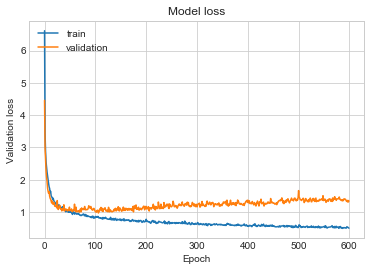

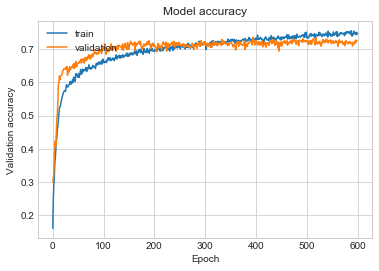

Loading Best Model
1.1149823630670832


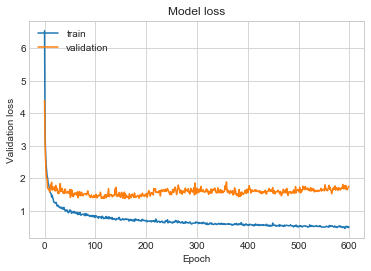

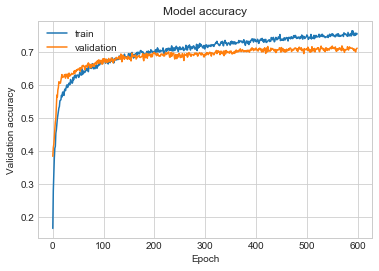

Loading Best Model
1.1077833740524945


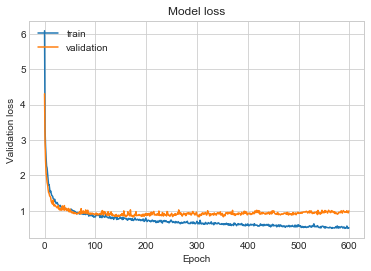

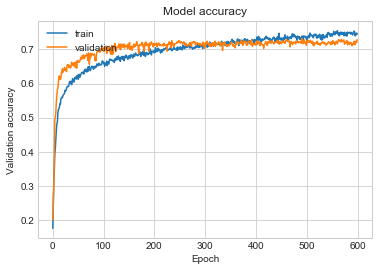

Loading Best Model
1.0216771012050851


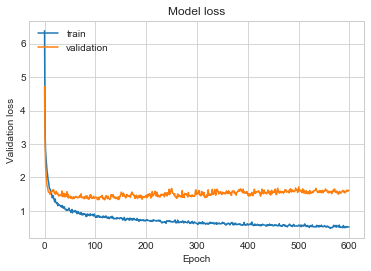

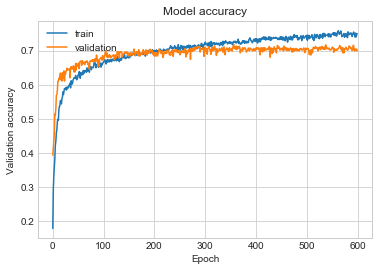

Loading Best Model
1.1562778896406585


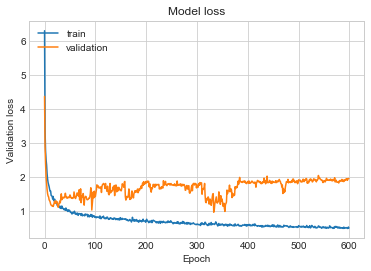

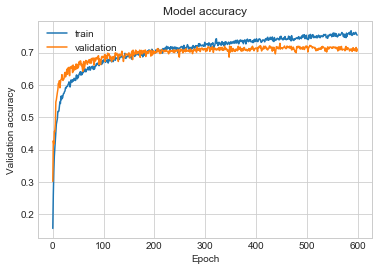

Loading Best Model
1.0860664299102805


In [19]:
#model learns from training set

classifiers = []
predictions = np.zeros((len(full_train_scaled), len(classes)))

for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
    filepath = 'weights.best.hdf5'
    
    checkPoint = ModelCheckpoint(filepath, monitor = 
                                'val_loss', mode = 'min',
                                save_best_only = True,
                                verbose = 0)
    x_train, y_train = full_train_scaled[trn_], y_categorical[trn_]
    x_valid, y_valid = full_train_scaled[val_], y_categorical[val_]
    
    model = build_model(dropout_rate = 0.5)
    #model.summary()
    model.compile(loss = mywloss, optimizer = 'adam',
                 metrics = ['accuracy'])
    
    history = model.fit(x_train, y_train, validation_data = 
                       [x_valid, y_valid], epochs = 600, 
                       batch_size = 100, shuffle = True,
                       verbose = 0, callbacks = [checkPoint])
    
    plot_loss_acc(history)
    
    print('Loading Best Model')
    model.load_weights(filepath)
    
    predictions[val_, :] = model.predict_proba(x_valid, batch_size = 100)
    print(multi_weighted_logloss(y_valid, predictions[val_, :]))
    classifiers.append(model)

In [20]:
print('OVERALL MULTI WEIGHTED LOG LOSS')
print(multi_weighted_logloss(y_categorical, predictions))

OVERALL MULTI WEIGHTED LOG LOSS
1.0969171245748603


In [21]:
#CONFUSION MATRIX
cm = confusion_matrix(y_map, np.argmax(predictions, axis = -1))
#classes contains all classes
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
print(cm)

[[9.53974895e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 4.18410042e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 4.18410042e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 8.83783784e-01 0.00000000e+00 6.48648649e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 2.97297297e-02
  0.00000000e+00 2.16216216e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.61525566e-01 5.69991618e-01
  0.00000000e+00 8.38222967e-04 1.08968986e-02 2.26320201e-02
  3.35289187e-03 1.14836547e-01 0.00000000e+00 0.00000000e+00
  1.50880134e-02 8.38222967e-04]
 [0.00000000e+00 4.32338954e-04 2.20492866e-02 9.08776481e-01
  4.32338954e-04 8.64677907e-04 5.18806744e-03 6.48508431e-03
  4.32338954e-04 5.27453524e-02 8.64677907e-04 4.32338954e-04
  1.29701686e-03 0.00000000e+00]
 [1.01936799e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.71457696e-01 2.75229358e-02 0.00000000e+00 0.00000000e+00


Text(0.5, 0, 'Predicted label')

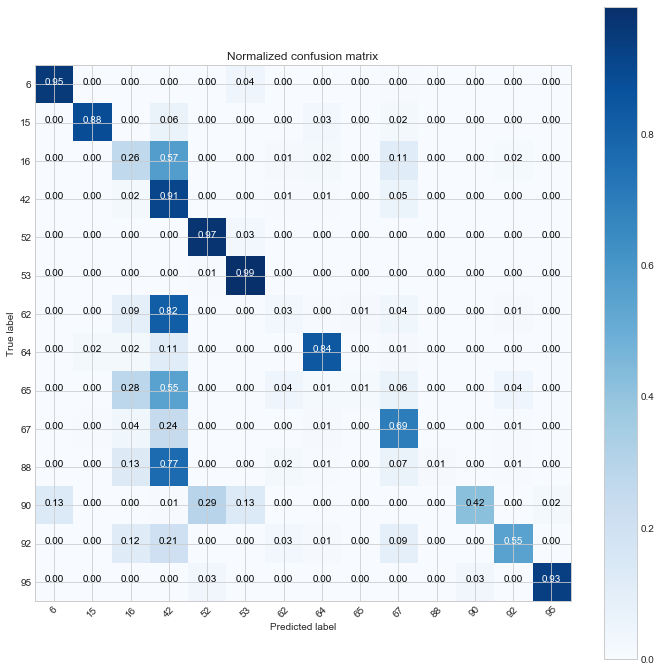

In [22]:
plt.figure(figsize=(12,12))

plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 45)
plt.yticks(tick_marks, classes)

fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment = 'center',
             color = 'white' if cm[i,j] > thresh else 'black')

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [47]:
#HOW IMPORTANT WAS EACH OF THE FEATURES IN CLASSIFICATION?
#this only allows us to see how many true positives are acquired.
#this is problematic for a multi-classification problem,
#but didn't find an appropriate metric to use in Keras
#to rectify the situation. 

#Least accurate scores reveal that a feature is highly correlated
#More accurate scores reveal that a feature might have been increasing
#the amount of loss; increasing uncertainty in ability to distinguish
#between two similar-looking classes


import copy

K.clear_session()
model = build_model(dropout_rate = 0.5)
model.load_weights('weights.best.hdf5')    

def permute_importance(fts):
    feats = copy.copy(fts)
    acc = []
    for i in range(fts.shape[1]):
        for j in range(fts.shape[0]):
            fts[j][i] = 0
        y_preds = pd.DataFrame(model.predict_proba(fts), columns = classes)
        y_preds['class'] = y_preds.idxmax(axis=1)
        accuracy = accuracy_score(y, y_preds['class'])
        acc.append(accuracy)
        fts = copy.copy(feats)
    return acc

permute_importance(full_train_scaled)

[0.06460244648318043,
 0.06422018348623854,
 0.06281855249745158,
 0.06230886850152905,
 0.0648572884811417,
 0.06294597349643222,
 0.04956676860346585,
 0.06358307849133538,
 0.06358307849133538,
 0.06358307849133538,
 0.063710499490316,
 0.063710499490316,
 0.06753312945973497,
 0.0640927624872579,
 0.06320081549439348,
 0.06549439347604485,
 0.07199286442405708,
 0.06574923547400612,
 0.0644750254841998,
 0.06422018348623854,
 0.06536697247706422,
 0.06867991845056065,
 0.06689602446483181,
 0.06460244648318043,
 0.06613149847094801,
 0.06574923547400612,
 0.0640927624872579,
 0.06396534148827727,
 0.06320081549439348,
 0.06651376146788991,
 0.06307339449541284,
 0.07352191641182466,
 0.06944444444444445,
 0.0648572884811417,
 0.06422018348623854,
 0.06778797145769623,
 0.07594291539245668,
 0.06982670744138635,
 0.06613149847094801,
 0.06791539245667685,
 0.06740570846075433,
 0.0640927624872579,
 0.06434760448521916,
 0.06460244648318043,
 0.06944444444444445,
 0.06600407747196738

In [24]:
#TEST SET PREDICTIONS

test_series = pd.read_csv('test_set_sample.csv')
test_metadata = pd.read_csv('test_set_metadata.csv')

#creating a list with all the unique object identifiers
test_ids = test_series['object_id'].unique()

In [25]:
def interpolate_signal_test(obj_id, band):
    
    #selecting time and flux data for the object
    t = (test_series.loc[test_series['object_id'] == obj_id][test_series['passband'] == band]['mjd'])
    f = (test_series.loc[test_series['object_id'] == obj_id][test_series['passband'] == band]['flux'])
    
    #cubic univariate spline function generation
    #where if loop handles case when there are 
    #three or less points
    if len(t) > 3:
        s0 = UnivariateSpline(t, f)
    elif len(t) == 3:
        s0 = UnivariateSpline(t, f, k=2)
    elif len(t) == 2:
        s0 = UnivariateSpline(t, f, k=1)
    elif len(t) == 1:
        s0 = UnivariateSpline(t, f, k=0)
    
    return s0, t.min(), t.max()

def single_dwt_test(obj_id, band):
    try: 
        #performing interpolation, selecting grid
        #in time (x) upon which to project
        interp, tmin, tmax = interpolate_signal_test(obj_id, band)
        x = np.linspace(tmin, tmax, 100) 
        y0 = interp(x)
    
        #padding the edges with constant values to
        #avoid edge effects from high-dimensional
        #wavelet transform
        y0 = pywt.pad(y0, 5, 'constant')
    
        #discrete wavelet transform on two levels using daubechies wavelet
        wav = pywt.wavedec(y0, wavelet = 'db1', level = 7)

        #concatenating the large-scale and small-scale frequencies detected
        wav_coefficients, wav_details = pywt.coeffs_to_array(wav)
    
    except: 
        wav_coefficients = np.zeros(112)
        wav_coefficients.fill(1e-15)
        
        print('Band ' + str(band) + ' in object ' + str(obj_id) + ' was not measured.')
    
    return wav_coefficients

def get_dynamic_feats_test():
    dynamic_feats = pd.DataFrame(test_ids, columns = ['object_id'])
    
    #populate columns with dwt for each band
    dynamic_feats['dwt_0'] = dynamic_feats.apply(lambda row: single_dwt_test(row['object_id'], 0), axis = 1)
    dynamic_feats['dwt_1'] = dynamic_feats.apply(lambda row: single_dwt_test(row['object_id'], 1), axis = 1)
    dynamic_feats['dwt_2'] = dynamic_feats.apply(lambda row: single_dwt_test(row['object_id'], 2), axis = 1)
    dynamic_feats['dwt_3'] = dynamic_feats.apply(lambda row: single_dwt_test(row['object_id'], 3), axis = 1)
    dynamic_feats['dwt_4'] = dynamic_feats.apply(lambda row: single_dwt_test(row['object_id'], 4), axis = 1)
    dynamic_feats['dwt_5'] = dynamic_feats.apply(lambda row: single_dwt_test(row['object_id'], 5), axis = 1)
    
    del dynamic_feats['object_id']
    
    return dynamic_feats

In [26]:
untransformed_test = get_dynamic_feats_test()
untransformed_test.head()

/Users/manojna/opt/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/manojna/opt/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/manojna/opt/anaconda3/lib/python3.7/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 7 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))
/Users/manojna/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


,dwt_0,dwt_1,dwt_2,dwt_3,dwt_4,dwt_5
0,"[-464.4516455560683, -253.95320435814182, 224....","[117.57893027197153, -124.60875315312632, 7.30...","[64.64653248809354, -65.5235277309806, -1.1969...","[-52.081933665605625, -82.98084564191785, 62.0...","[70.9136575441433, -255.7402629666754, 20.6291...","[193.3518509068003, -194.62937081223922, 200.3..."
1,"[-211.49109530927262, 57.329214160742126, 13.4...","[39.136246272379694, 42.321146395759115, -0.82...","[3.7564071393820218, 19.296330395562038, 13.18...","[2.8444843369996917, -12.75433222151351, 32.34...","[143.9763470295174, -81.43132567930867, -15.71...","[-170.1007987169703, 266.2990946904442, 34.939..."
2,"[-127.49052844868142, 182.9934723794571, 70.29...","[-30.659899502972827, 20.2524883317231, 3.3384...","[20.443938537118992, -22.272413076742776, -0.5...","[-77.68950960590371, 39.00270509598195, 11.587...","[-42.565423720189145, -102.78424226303964, 43....","[182.27971571240795, -103.55201199600725, 53.0..."
3,"[-102.53156557231924, 162.58416253560208, 28.7...","[-14.014215485719872, 2.169028651159975, 6.546...","[-8.132850795911837, 17.718533819065698, -11.9...","[93.28769500174403, 43.679623743555595, -64.79...","[5.459048470935265, -21.300665235904198, -2.38...","[-524.514587501631, 361.95319612718947, 50.001..."
4,"[-343.8719508133456, -119.31461298437694, -87....","[-100.02928284612781, 138.62290509766038, -19....","[104.62168833391, -22.653500801791637, -59.265...","[58.64520742941385, 59.91005829740663, -71.052...","[130.45550068354456, -52.06137049108696, -43.5...","[3.1971896343011235, -15.343254819755435, -50...."


In [27]:
def covar_PCA_test(band):
    #reshaping the array so that
    #the covariance matrix can be applied
    oldwav_test = pd.DataFrame((untransformed_test['dwt_{}'.format(band)]).tolist())
    oldwav_test = oldwav_test.values
    m, n = oldwav_test.shape
    #centering the data around the mean
    #for each coefficient
    oldwav_test -= oldwav_test.mean(axis = 0)
    
    #calculating the covariance matrix
    covar = np.cov(oldwav_test, rowvar = False)
    #calculating the eigenvalues and eigenvectors
    #of the (symmetrical) covariance matrix
    evals, evecs = linalg.eigh(covar)
    
    #sorting eigenvalues in decreasing order
    #while keeping indices consistent between
    #evals and evecs
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:, idx]
    evals = evals[idx]
    #selecting the most important eigenvector
    evecs = evecs[:, :1]
    
    newwav = np.dot(evecs.T, oldwav_test.T).T
    
    return newwav #newwav

def fit_multiband_test(obj_id):
    #time, flux, flux error, and passband series
    t = test_series[test_series['object_id'] == obj_id]['mjd']
    f = test_series[test_series['object_id'] == obj_id]['flux']
    e = test_series[test_series['object_id'] == obj_id]['flux_err']
    b = test_series[test_series['object_id'] == obj_id]['passband']
    
    #parameterizing and fitting the model
    model = periodic.LombScargleMultibandFast(fit_period= True);
    
    #period range chosen on the assumption that
    #the period will be between 2.4 hours and half
    #of the observation window
    model.optimizer.period_range = (0.1, int((t.max()-t.min())/2));
    model.fit(t, f, e, b);
    
    #accuracy of fit for the model's best predicted period
    best_period_score = model.score(model.best_period);
    
    #returns tuple of best predicted period and its fit score
    return [model.best_period, float(best_period_score)]

def extragalactic_benchmark_test(obj_id):
    #selecting the host galaxy redshift of the object
    #from the metadata; if it is 0, then the object
    #has been observed within the Milky Way
    hg_redshift = float(test_metadata[test_metadata['object_id'] == obj_id]['hostgal_photoz'])
    
    #will return true if the object is extragalactic
    if hg_redshift == 0:
        return False
    else:
        return True

In [28]:
gc.enable() 

#extracting descriptive statistics about the time series
statistical_features = {
    'mjd': ['min', 'max', 'size'],
    'flux': ['min', 'max', 'mean', 'median', 'std'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std', 'skew'],
    'detected': ['mean']}

#simplifying the dataframe
test_feat = test_series.groupby(['object_id', 'passband']).agg(statistical_features)
new_columns = [k + '_' + agg for k in statistical_features.keys() for agg in statistical_features[k]]
test_feat.columns = new_columns

#considering the delta of time and flux
#for each object in each passband
test_feat['mjd_diff'] = test_feat['mjd_max']-test_feat['mjd_min']
test_feat['flux_diff'] = test_feat['flux_max']-test_feat['flux_min']
del test_feat['mjd_max'], test_feat['mjd_min']

gc.collect()

#creating the dataframe based on object id
rearranged_test = pd.DataFrame(test_ids, columns = ['object_id'])

for band in bands:
    banddata = test_feat.groupby(['passband']).get_group(band)

    rearranged_test['mjd_size_{}'.format(band)] = np.asarray(banddata['mjd_size'])
    rearranged_test['flux_min_{}'.format(band)] = np.asarray(banddata['flux_min'])
    rearranged_test['flux_max_{}'.format(band)] = np.asarray(banddata['flux_max'])
    rearranged_test['flux_mean_{}'.format(band)] = np.asarray(banddata['flux_mean'])
    rearranged_test['flux_median_{}'.format(band)] = np.asarray(banddata['flux_median'])
    rearranged_test['flux_std_{}'.format(band)] = np.asarray(banddata['flux_std'])
    rearranged_test['detected_mean_{}'.format(band)] = np.asarray(banddata['detected_mean'])
    rearranged_test['flux_err_min_{}'.format(band)] = np.asarray(banddata['flux_err_min'])
    rearranged_test['flux_err_max_{}'.format(band)] = np.asarray(banddata['flux_err_max'])
    rearranged_test['flux_err_mean_{}'.format(band)] = np.asarray(banddata['flux_err_mean'])
    rearranged_test['flux_err_median_{}'.format(band)] = np.asarray(banddata['flux_err_median'])
    rearranged_test['flux_err_std_{}'.format(band)] = np.asarray(banddata['flux_err_std'])
    rearranged_test['flux_err_skew_{}'.format(band)] = np.asarray(banddata['flux_err_skew'])
    rearranged_test['mjd_diff_{}'.format(band)] = np.asarray(banddata['mjd_diff'])
    rearranged_test['flux_diff_{}'.format(band)] = np.asarray(banddata['flux_diff'])

rearranged_test.head()

,object_id,mjd_size_0,flux_min_0,flux_max_0,flux_mean_0,flux_median_0,flux_std_0,detected_mean_0,flux_err_min_0,flux_err_max_0,...,flux_std_5,detected_mean_5,flux_err_min_5,flux_err_max_5,flux_err_mean_5,flux_err_median_5,flux_err_std_5,flux_err_skew_5,mjd_diff_5,flux_diff_5
0,13,72,-4.067552,5.816270,0.402818,0.087326,2.060904,0.000000,1.122888,3.087183,...,12.104127,0.117647,4.170574,11.257108,5.998146,5.701680,1.306351,1.479297,853.8084,49.482325
1,14,72,-4.116055,6.371965,0.315396,-0.034459,2.372227,0.000000,1.120789,3.073875,...,5.488778,0.000000,4.159950,11.249375,5.992656,5.693579,1.306648,1.474865,853.8084,25.981591
2,17,63,-7.464523,6.056491,0.095728,0.252658,2.770631,0.000000,1.158724,3.532677,...,6.822252,0.000000,4.548802,11.278636,6.461260,5.973135,1.425933,1.109214,871.7697,30.964024
3,23,72,-4.667993,3.919783,0.010791,-0.129384,2.062264,0.000000,1.142142,3.127708,...,7.685845,0.000000,4.180651,11.305429,6.022865,5.717759,1.313305,1.475110,853.8084,40.693061
4,34,63,-7.241933,19.174976,1.032765,0.582256,4.103085,0.031746,1.193847,3.640227,...,20.415023,0.052632,4.582389,11.365292,6.514264,6.021321,1.435883,1.108148,871.7697,104.000266


In [29]:
#del test_metadata['ra'], test_metadata['decl'], test_metadata['gal_l'], test_metadata['gal_b'], test_metadata['distmod']
#del test_metadata['hostgal_specz']
#del test_metadata['mwebv'], test_metadata['ddf']

#gc.collect()

test_metadata = test_metadata[test_metadata['object_id'].isin(test_ids)]

test_metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv
0,13,34.453125,-5.229529,169.987075,-59.956185,1,0.3048,0.3193,0.0542,41.1123,0.019
1,14,33.398438,-4.331149,167.226341,-59.936551,1,NaN,0.6323,0.0179,42.8774,0.018
2,17,348.529419,-61.755440,321.293980,-51.763351,1,NaN,0.8297,0.0605,43.6000,0.016
3,23,34.804688,-5.829153,171.307861,-60.174401,1,NaN,0.6533,0.1479,42.9640,0.023
4,34,351.321442,-64.198746,317.458993,-50.429931,1,0.4557,0.4617,0.0122,42.0540,0.023


In [30]:
%%capture
#merge extracted features with metadata

#adding features from discrete wavelet transform
test_metadata['wav_coeffs_0'] = covar_PCA_test(0)
test_metadata['wav_coeffs_1'] = covar_PCA_test(1)
test_metadata['wav_coeffs_2'] = covar_PCA_test(2)
test_metadata['wav_coeffs_3'] = covar_PCA_test(3)
test_metadata['wav_coeffs_4'] = covar_PCA_test(4)
test_metadata['wav_coeffs_5'] = covar_PCA_test(5)

#adding features from Lomb Scargle multiband fit
test_metadata['periodicity'] = test_metadata.apply(lambda row: fit_multiband_test(row['object_id']), axis = 1)

#adding extragalactic naive benchmark
test_metadata['extragalactic'] = test_metadata.apply(lambda row: extragalactic_benchmark_test(row['object_id']), axis = 1)

In [125]:
#merging timeseries with metadata
full_test = rearranged_test.reset_index().merge(
    right = test_metadata,
    how = 'outer',
    on = 'object_id')

#creating series for object identifiers
obj_ids = full_test['object_id']
del full_test['object_id'], full_test['index']

gc.collect()

#separating features given as arrays so
#that the training array plays well with Keras
full_test['best_period'] = full_test.apply(lambda row: row['periodicity'][0], axis = 1)
full_test['period_score'] = full_test.apply(lambda row: row['periodicity'][1], axis = 1)

del full_test['periodicity'], full_test['ra'], full_test['gal_b'], full_test['ddf'], full_test['gal_l'], full_test['mwebv'], full_test['hostgal_specz']
del full_test['decl'], full_test['distmod']

gc.collect()

#checking to see if there are any NaNs
#idx, idy = np.where(full_train.isnull())
#problem = np.column_stack([full_train.index[idx], full_train.columns[idy]])
#print(problem)

#replacing NaNs with a small non-zero number
full_test.fillna(1e-15, inplace = True)

ss = StandardScaler()
full_test_scaled = ss.fit_transform(full_test.copy())

In [126]:
K.clear_session()

In [127]:
build_model(dropout_rate = 0.5)
model.load_weights('weights.best.hdf5')
preds = model.predict_proba(full_test_scaled)

# Compute preds_99 as the proba of class not being any of the others
preds_99 = np.ones(preds.shape[0])
for i in range(preds.shape[1]):
    preds_99 *= (1 - preds[:, i])
    
# Store predictions
preds_df = pd.DataFrame(preds, columns = classes)
preds_df['99'] = 0.14 * preds_99 / np.mean(preds_99) 
preds_df.head()

TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("Placeholder:0", shape=(101, 512), dtype=float32) is not an element of this graph.

In [ ]:
#TEST SET CONFUSION MATRIX

#UPLOAD TARGETS FOR THIS SAMPLE SET AND THEN CONFUSION MATRIX CAN BE CALCULATED
#FROM METADATA
#MIGHT NEED TO ONE-HOT ENCODE THE TRUE CLASSES

In [120]:
test_meta = pd.read_csv('plasticc_test_metadata.csv')
test_meta = test_meta[test_meta['object_id'].isin(test_ids)]

y = np.array(test_meta['true_target'])

#replace true_target specific class 99
#values with mere 99
y = np.where(y == 993, 99, y)
y = np.where(y == 991, 99, y)
y = np.where(y == 992, 99, y)


class_map = dict()
for i, val in enumerate(allclasses):
    class_map[val] = i

y_map_test = np.zeros((y.shape[0],))
y_map_test = np.array([class_map[val] for val in y])

print(class_map)

{6: 0, 15: 1, 16: 2, 42: 3, 52: 4, 53: 5, 62: 6, 64: 7, 65: 8, 67: 9, 88: 10, 90: 11, 92: 12, 95: 13, 99: 14}


In [137]:
#del preds_df['target']
#preds_test = np.array(preds_df)
#target_index = np.argmax(preds_test, axis = 1)
#print(target_index)
#preds_df['target'] = target_index

preds_df.head()

print(preds_df['target'].unique())

[ 2  5  3  4  7  9 12  6 13  1  0  8 11]


In [138]:
#CONFUSION MATRIX
cm = confusion_matrix(y_map_test, preds_df['target'])
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
print(cm)

[[           nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan]
 [0.00000000e+00 2.50000000e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 2.50000000e-01
  0.00000000e+00 2.50000000e-01 0.00000000e+00 0.00000000e+00
  2.50000000e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 8.70730074e-03 2.31078366e-01 3.16811788e-01
  4.68854655e-02 1.09176155e-01 1.00468855e-02 6.49698593e-02
  3.34896182e-03 9.64501005e-02 0.00000000e+00 6.69792364e-04
  1.09845948e-01 2.00937709e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.28947368e-01 2.36842105e-01
  

/Users/manojna/opt/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Text(0.5, 0, 'Predicted label')

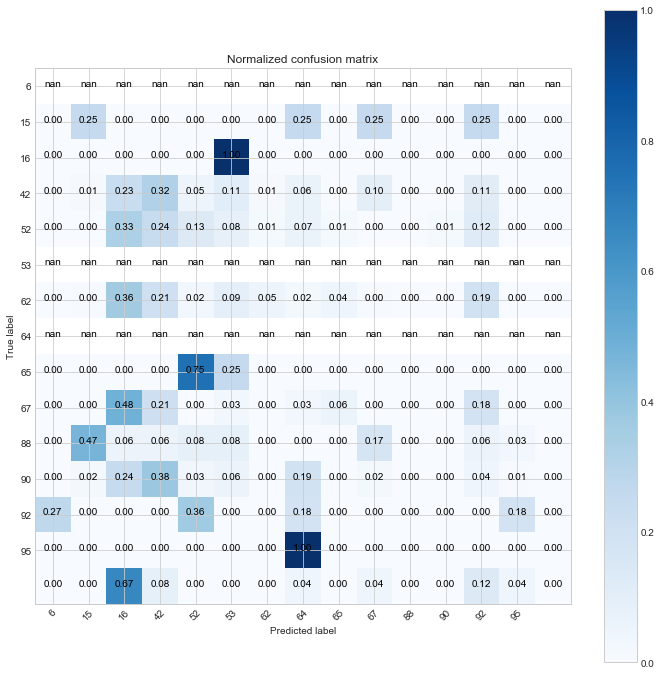

In [139]:
plt.figure(figsize=(12,12))

plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 45)
plt.yticks(tick_marks, classes)

fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment = 'center',
             color = 'white' if cm[i,j] > thresh else 'black')

plt.ylabel('True label')
plt.xlabel('Predicted label')